# Graph Resilience

In this notebook, we will analyze the connectivity of a computer network as it undergoes a cyber-attack. In particular, we will simulate an attack on this network in which an increasing number of servers are disabled.  To this end, we will model the network by an undirected graph and repeatedly delete nodes from this graph. We will then measure the resilience of the graph in terms of the size of the largest remaining connected component as a function of the number of nodes deleted.

## Graphs used
In addition to the computer network available [here](http://storage.googleapis.com/codeskulptor-alg/alg_rf7.txt), we will also compute the resilience of two other randomly generated undirected graphs. The first random graph (FRG) will be created such that the probability of having an edge between any two different nodes is fixed. The second random graph (SRG) is iteratively created such that there is an undirected edge `(i, j)` between `i` and `j` with a dynamically changing probability `(deg(j) + 1) / (total_deg + number of existing nodes)`. This probability is directly proportional to the number of edges node `j` already has, and we are adding 1 to make sure that nodes with 0 degrees have a chance to receive an edge. Since we are adding 1 to the numerator of each node, we should also add the number of existing nodes to the denominator.

## Loading the data
First, we will load the data and create a graph to represent it. The computer network consists of 1,239 computers and 3,047 edges. The computer connected to the largest number of other computers has 96 edges, and we see that all computers are connected to at least one other computer.

In [13]:
from collections import deque
from copy import deepcopy
from urllib.request import urlopen, Request
from functools import partial
import re
import random
import math
import time
import matplotlib.pyplot as plt

NETWORK_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_rf7.txt"

def create_ugraph(url):
    """
    Reading a graph in txt format from the web.

    Returns a dictionary whose keys are nodes of the graph,
    and values are the nodes with which there is an edge.
    """

    request = Request(url)
    response = urlopen(request)
    text_graph = response.readlines()
    response.close()
    ugraph = {}
    for line in text_graph:
        str_line = re.findall(b"\d+", line)
        key = int(str_line[0])
        values = [int(value) for value in str_line[1:]]
        ugraph[key] = set(values)

    return ugraph

COMPUTER_NETWORK = create_ugraph(NETWORK_URL)
print("Number of nodes", len(COMPUTER_NETWORK))
print("The number of edges is", sum(len(value) for value in COMPUTER_NETWORK.values()) // 2)
print("max number of edges", max(len(value) for value in COMPUTER_NETWORK.values()))
print("min number of edges", min(len(value) for value in COMPUTER_NETWORK.values()))

Number of nodes 1239
The number of edges is 3047
max number of edges 96
min number of edges 1


## Helper functions
Now, we will write several helper functions, including the one plotting the runtime of other functions, so that we can benefit from them in this and in the next projects.

In [23]:
def make_frg(num_nodes, prob):
    """
    Creates an undirected FRG graph with num_nodes
    wherein the probability of having an edge between
    any two different nodes is equal to prob.

    Returns a dictionary whose keys are nodes of the graph,
    and values are the nodes with which there is an edge.
    """
    ugraph = {}
    for node in range(num_nodes):
        ugraph[node] = set()

    for node in ugraph:
        for neighbour in range(node + 1, num_nodes):
            edge_prob = random.random()
            if edge_prob < prob:
                ugraph[node].add(neighbour)
                ugraph[neighbour].add(node)

    return ugraph

def make_srg(num_nodes, num_neighbours):
    """
    Creates an undirected graph wherein there is an edge
    from each new node to num_neighbours of existing nodes.
    The probability of an existing node i being chosen in
    this process is (deg(i) + 1) / (total_deg + the number
    of existing nodes).

    Returns a dictionary whose keys are nodes, and values
    are the nodes with which there is an edge.
    """
    ugraph = {}

    # adding nodes 0 to num_neighbours - 1
    initial_nodes = range(num_neighbours)
    for node in initial_nodes:
        neighbours = set(initial_nodes)
        neighbours.remove(node)
        ugraph[node] = neighbours

    nodes_to_choose = [node for node in ugraph
                       for _ in range(num_neighbours)]

    # adding nodes num_neighbours to num_nodes - 1
    for node in range(num_neighbours, num_nodes):
        neighbours = set(random.choices(nodes_to_choose, k=num_neighbours))
        ugraph[node] = neighbours
        nodes_to_choose.extend(neighbours)
        nodes_to_choose.append(node)
        for neighbour in neighbours:
            ugraph[neighbour].add(node)
            nodes_to_choose.append(node)

    return ugraph

def calculate_node_edge(ugraph):
    """
    Calculates the number of nodes and edges in an
    undirected graph ugraph.

    Returns a tuple containing these statistics.
    """
    nodes = len(ugraph)
    edges = 0
    for neighbour_set in ugraph.values():
        edges += len(neighbour_set)

    return (nodes, edges // 2)

def delete_node(ugraph, node):
    """
    Deletes a node from an undirected graph.
    """
    neighbours = ugraph.pop(node)
    for neighbour in neighbours:
        ugraph[neighbour].remove(node)

def bfs_visited(ugraph, start_node):
    """
    Takes an undirected graph ugraph and a node
    start_node and computes the set consisting of
    all nodes that are visited by a breadth-first
    search that starts at the start_node.
    """
    queue = deque()
    visited = {start_node}
    queue.append(start_node)
    while len(queue) > 0:
        node = queue.popleft()
        neighbours = ugraph[node]
        for neighbour in neighbours:
            if neighbour not in visited:
                visited.add(neighbour)
                queue.append(neighbour)

    return visited

def cc_visited(ugraph):
    """
    Takes an undirected graph ugraph and returns
    a list of sets where each set consists of all
    the nodes in a connected component.
    """
    remaining_nodes = set(ugraph.keys())
    connected_comps = []
    while len(remaining_nodes) > 0:
        node = remaining_nodes.pop()
        component = bfs_visited(ugraph, node)
        connected_comps.append(component)
        remaining_nodes.difference_update(component)

    return connected_comps

def largest_cc_size(ugraph):
    """
    Takes an undirected graph ugraph and returns
    the size (an integer) of the largest connected
    component in ugraph.
    """
    connected_comps = cc_visited(ugraph)
    max_size = 0
    for component in connected_comps:
        if len(component) > max_size:
            max_size = len(component)

    return max_size

def plot_resilience(computer_network_graph, attack_func,
                    resilience_func, fraction=1):
    """
    Plots the resilience of the computer_network_graph,
    an FRG graph, and a SRG graph under the attack
    order given by `attack_func`. The fraction of the
    nodes to be removed in this process is set by
    `fraction`, and the `resilience_func` specifies the
    algorithm used to compute the size of the largest 
    connected component as nodes are removed.

    The FRG and SRG graphs are generated such that they
    have the same number of nodes and approximately the
    same number of egdes as the computer_network_graph.

    Returns None.
    """
    num_nodes, num_edges = calculate_node_edge(computer_network_graph)
    frg_prob = num_edges / (num_nodes ** 2 / 2)
    frg_graph = make_frg(num_nodes, frg_prob)
    srg_neighbours = math.ceil(num_edges / num_nodes)
    srg_graph = make_srg(num_nodes, srg_neighbours)
    graphs = [computer_network_graph, frg_graph, srg_graph]
    colors = ["blue", "red", "green"]
    labels = ["Computer network", "FRG graph (p = 0.004)", "SRG graph (m = 3)"]

    # plotting the graphs
    plt.style.use("bmh")
    fig, ax = plt.subplots()
    display_length = int(round(len(computer_network_graph) * fraction, 0))
    for graph in graphs:
        attack_order = attack_func(graph)[ : display_length]
        resilience_graph = resilience_func(graph, attack_order)
        ax.plot(list(range(0, display_length + 1)), resilience_graph,
                label=labels.pop(0), color=colors.pop(0))

    ax.set_xlabel("Number of removed nodes")
    ax.set_ylabel("Largest connected component size")
    ax.set_title("Resilience of graphs")
    ax.legend()
    plt.show()

def plot_running_time(axes, start_val, end_val, step, outer_func, inner_func,
                      arg_func=None, label="", color="blue", title=""):
    """
    Plots the running time of a function func_inner
    whose inputs are generated by a function func_outer
    for the input sizes in range(start_val, end_val, step).

    Modifies the gives axes object.
    """
    size_lst = []
    time_lst = []
    for input_size in range(start_val, end_val, step):
        outer_func_result = outer_func(input_size)
        if arg_func is not None:
            argument = arg_func(outer_func_result)
            start_time = time.time()
            inner_func(outer_func_result, argument)
        else:
            start_time = time.time()
            inner_func(outer_func_result)

        end_time = time.time()
        size_lst.append(input_size)
        time_lst.append(end_time - start_time)

    axes.plot(size_lst, time_lst, label=label, color=color)
    axes.set_xlabel("Input size")
    axes.set_ylabel("Running time (seconds)")
    axes.set_title(title)

## Plotting the resilience
We can now examine the resilience of the computer network under an attack in which servers are chosen at random. Then, we will compare the resilience of the network to the resilience of FRG and SRG graphs of similar size. To make sure that all 3 graphs have approximately the same number of edges, we will choose the probability of $p = \frac{|E|}{0.5|V|^2}$ for the first graph and the expected degree of $m = \left \lceil{\frac{|E|}{|V|}}\right \rceil$ for the second graph.

In passing, we want to clarify that we mean xxx when we say resilience. the size of the largest connected component 


In [20]:
num_nodes, num_edges = calculate_node_edge(COMPUTER_NETWORK)
frg_prob = num_edges / (num_nodes ** 2 / 2)
print("The probability of an edge is", frg_prob)
srg_neighbours = math.ceil(num_edges / num_nodes)
print("The expected number of neighbours is", srg_neighbours)

The probability of an edge is 0.003969719650763686
The expected number of neighbours is 3


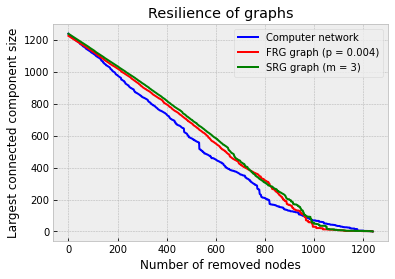

In [21]:
def random_order(iterator):
    """
    Returns a list wherein items in the iterator
    are shuffled randomly.
    """
    output_list = list(iterator)
    random.shuffle(output_list)
    return output_list

def compute_resilience_bfs(ugraph, attack_order):
    """
    Takes an undirected graph ugraph, a list of nodes
    attack_order and returns a list whose k + 1 th entry
    is the size of the largest connected component in
    the graph after the removal of the first k nodes in
    attack_order. The first entry is the size of the
    largest connected component in the original graph.

    Uses a breadth-first search.
    """
    ugraph_copy = deepcopy(ugraph)
    resilience_list = deque([largest_cc_size(ugraph_copy)])
    for attack in attack_order:
        delete_node(ugraph_copy, attack)
        resilience_list.append(largest_cc_size(ugraph_copy))

    return resilience_list

plot_resilience(COMPUTER_NETWORK, random_order, 
                compute_resilience_bfs, fraction=1)

In [ ]:



# plotting the resilience of the graphs under random_order
plot_resilience(COMPUTER_NETWORK, random_order, fraction=1)
plot_resilience(COMPUTER_NETWORK, random_order, fraction=0.2)

# complexities of targeted_order vs fast_targeted_order
plt.style.use("bmh")
fig, ax = plt.subplots()
plot_running_time(ax, 10, 1000, 10, partial(make_upa, num_neighbours=5),
                  targeted_order, arg_func=None,
                  label="targeted_order", color="blue")
plot_running_time(ax, 10, 1000, 10, partial(make_upa, num_neighbours=5),
                  fast_targeted_order, arg_func=None,
                  label="fast_targeted_order", color="red")
ax.legend()
ax.set_title("Desktop Python complexities of targeted attacks")
plt.show()
fig.savefig("Task 3.png", dpi=300)

# plotting the resilience of the graphs under fast_targeted_order
plot_resilience(COMPUTER_NETWORK, fast_targeted_order, fraction=1)
plot_resilience(COMPUTER_NETWORK, fast_targeted_order, fraction=0.2)




In [ ]:
class DisjointSet:
    """
    Creates a disjoint set using an implementation based
    on the forest of balanced trees.
    """

    def __init__(self):
        """
        Initializes 3 dictionaries: The first two dictionaries
        store the parent and rank of a node.
        The third one stores the size of a set.
        """
        self._node_parent = {}
        self._node_rank = {}
        self._set_size = {}
        self._max_size = 0

    def __str__(self):
        """
        Returns a string representation of the disjoint sets.
        """
        string = "Parent nodes " + str(self._node_parent)
        string += "\n"
        string += "Ranks " + str(self._node_rank)
        string += "\n"
        string += "Set sizes " + str(self._set_size)
        string += "\n"
        string += "Max size " + str(self._max_size)
        string += "\n"
        return string

    def make_set(self, node):
        """
        Creates a set from a node whose parent node
        is the node itself.
        """
        assert (node not in self._node_parent), "The node already exists."
        self._node_parent[node] = node
        self._node_rank[node] = 0
        self._set_size[node] = 1
        if self._max_size == 0:
            self._max_size = 1

    def find_set(self, node):
        """
        Finds the parent of a node and does path
        compression along the way.
        """
        if node not in self._node_parent:
            return None

        parent_node = self._node_parent[node]
        if parent_node == node:
            return parent_node

        self._node_parent[node] = self.find_set(parent_node)
        return self._node_parent[node]

    def union(self, node1, node2):
        """
        Unites two nodes based on the ranks of their
        corresponding sets. A shorter set is merged
        into the taller set.

        Updates the size of the largest set if applicable.
        """
        set1 = self.find_set(node1)
        set2 = self.find_set(node2)
        if set1 == set2:
            return
        elif (set1 is None) or (set2 is None):
            return

        rank1 = self._node_rank[set1]
        rank2 = self._node_rank[set2]
        total_size = self._set_size[set1] + self._set_size[set2]
        if rank1 > rank2:
            self._node_parent[set2] = set1
            self._set_size[set1] = total_size
        elif rank1 < rank2:
            self._node_parent[set1] = set2
            self._set_size[set2] = total_size
        else:
            self._node_parent[set1] = set2
            self._set_size[set2] = total_size
            self._node_rank[set2] += 1

        if total_size > self._max_size:
            self._max_size = total_size

    def get_max_size(self):
        """
        Returns the size of the largest set.
        """
        return self._max_size

    @classmethod
    def compute_resilience(cls, ugraph, attack_order):
        """
        Takes an undirected graph ugraph, a list of nodes
        attack_order and returns a list whose k + 1 th entry
        is the size of the largest connected component in
        the graph after the removal of the first k nodes in
        attack_order. The first entry is the size of the
        largest connected component in the original graph.

        Uses disjoint sets.
        """
        djs_set = cls()

        # merging nodes that are not in attack_order
        attack_set = set(attack_order)
        for node in ugraph:
            if node not in attack_set:
                djs_set.make_set(node)

        for node, neighbours in ugraph.items():
            for neighbour in neighbours:
                djs_set.union(node, neighbour)

        # merging nodes that are in attack_order
        resilience_list = deque([djs_set.get_max_size()])
        for attack in reversed(attack_order):
            djs_set.make_set(attack)
            neighbours = ugraph[attack]
            for neighbour in neighbours:
                djs_set.union(attack, neighbour)

            resilience_list.appendleft(djs_set.get_max_size())

        return resilience_list

In [ ]:


def targeted_order(ugraph):
    """
    Computes a targeted attack order consisting
    of nodes of maximal degree.

    Returns a list of nodes.
    """
    ugraph_copy = deepcopy(ugraph)
    order = []
    while len(ugraph_copy) > 0:
        max_degree = -1
        for node in ugraph_copy:
            if len(ugraph_copy[node]) > max_degree:
                max_degree = len(ugraph_copy[node])
                max_degree_node = node

        delete_node(ugraph_copy, max_degree_node)
        order.append(max_degree_node)
    return order

def fast_targeted_order(ugraph):
    """
    Computes a targeted attack order consisting
    of nodes of maximal degree.

    Returns a list of nodes.
    """
    ugraph_copy = deepcopy(ugraph)
    degree_sets = {}
    for degree in range(len(ugraph_copy)):
        degree_sets[degree] = set()

    for node in ugraph_copy:
        node_degree = len(ugraph_copy[node])
        degree_sets[node_degree].add(node)

    order = []
    for degree in range(len(ugraph) - 1, -1, -1):
        while len(degree_sets[degree]) > 0:
            max_degree_node = degree_sets[degree].pop()
            neighbours = ugraph_copy[max_degree_node]
            for neighbour in neighbours:
                neighbour_degree = len(ugraph_copy[neighbour])
                degree_sets[neighbour_degree].remove(neighbour)
                degree_sets[neighbour_degree - 1].add(neighbour)

            order.append(max_degree_node)
            delete_node(ugraph_copy, max_degree_node)

    return order

class TestSuite:
    """
    Create a suite of tests similar to unittest
    """
    def __init__(self):
        """
        Creates a test suite object
        """
        self._total_tests = 0
        self._failures = 0

    def run_test(self, computed, expected, message=""):
        """
        Compare computed and expected
        If not equal, print message, computed, expected
        """
        self._total_tests += 1
        if computed != expected:
            msg = message + " Computed: " + str(computed)
            msg += " Expected: " + str(expected)
            print(msg)
            self._failures += 1

    def report_results(self):
        """
        Report back summary of successes and failures
        from run_test()
        """
        msg = "Ran " + str(self._total_tests) + " tests. "
        msg += str(self._failures) + " failures."
        print(msg)

# informal tests of functions
def run_suite():
    """
    Some informal testing code
    """

    # creating a TestSuite object
    suite = TestSuite()

    # testing bfs functions
    ugraph = {0: set([3, 2]),
              1: set([6, 7]),
              2: set([3, 5, 0]),
              3: set([0, 2, 4]),
              4: set([5]),
              5: set([4, 2]),
              6: set([7, 1]),
              7: set([6, 1])}
    suite.run_test(bfs_visited(ugraph, 0), set([0, 2, 3, 4, 5]),
                   "Test 1.1: BFS_visited")
    suite.run_test(cc_visited(ugraph), [set([0, 2, 3, 4, 5]), set([1, 6, 7])],
                   "Test 2.1: cc_visited")
    suite.run_test(largest_cc_size(ugraph), 5, "Test 3.1: largest_cc_size")
    suite.run_test(compute_resilience_bfs(ugraph, [0, 6, 2]), deque([5, 4, 4, 3]),
                   "Test 4.1: compute_resilience_bfs")

    ugraph = {0: set([3, 2]),
              1: set([6, 7]),
              2: set([3, 5, 0]),
              3: set([1, 0, 2, 4]),
              4: set([5]),
              5: set([4]),
              6: set([7, 1]),
              7: set([6, 1])}
    suite.run_test(bfs_visited(ugraph, 0), set(range(8)),
                   "Test 1.2: BFS_visited")
    suite.run_test(cc_visited(ugraph), [set(range(8))],
                   "Test 2.2: cc_visited")
    suite.run_test(largest_cc_size(ugraph), 8, "Test 3.2: largest_cc_size")

    ugraph = {0: set([]),
              1: set([2, 3, 5]),
              2: set([4, 7]),
              3: set([]),
              4: set([5]),
              5: set([1]),
              6: set(range(1, 8)),
              7: set(range(1, 8))}
    suite.run_test(bfs_visited(ugraph, 1), set(range(1, 8)),
                   "Test 1.3: BFS_visited")
    suite.run_test(cc_visited(ugraph), [set([0]), set(range(1, 8))],
                   "Test 2.3: cc_visited")
    suite.run_test(largest_cc_size(ugraph), 7, "Test 3.3: largest_cc_size")

    # testing the class: __init__ and __str__methods
    test_set = DisjointSet()

    # testing the make_set method
    for node in range(32):
        test_set.make_set(node)

    # testing the union and find_set methods
    for step in [1, 2, 4, 8]:
        for node in range(step // 2, 32, 2 * step):
            test_set.union(node, node + step)
    print(test_set)

    # testing the compute_resilience method
    graph_idx = 0
    computer_network = create_ugraph(NETWORK_URL)
    num_nodes, num_edges = calculate_node_edge(computer_network)
    frg_prob = num_edges / (num_nodes ** 2 / 2)
    frg_graph = make_frg(num_nodes, frg_prob)
    srg_neighbours = num_edges // num_nodes + 1
    srg_graph = make_srg(num_nodes, srg_neighbours)

    input_graphs = [computer_network, frg_graph, srg_graph]
    for graph in input_graphs:
        attack_order = random_order(graph)
        ds_result = DisjointSet.compute_resilience(graph, attack_order)
        bfs_result = compute_resilience_bfs(graph, attack_order)
        suite.run_test(ds_result, bfs_result,
                       "Test 5." + str(graph_idx) + ": compute_resilience_ds")
        graph_idx += 1

    # reporting the results of the test
    suite.report_results()

run_suite()